In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0

import numpy as np
np.random.seed = 333

# Prepare data

In [2]:
from carl.distributions import Mixture, MultivariateNormal, Uniform, Normal

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.array([[1., -0.5], [-0.5, 1.]]))
p1 = MultivariateNormal(mu=np.array([1., 1.]), sigma=np.eye(2))
pz = Normal(mu=0.0, sigma=1.0)

In [3]:
n_samples = 125000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

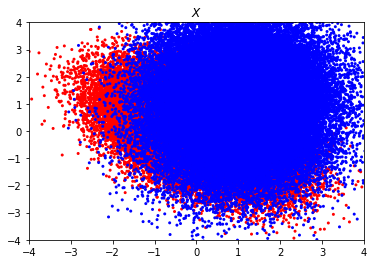

In [4]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker=".", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker=".", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=50000)

# Set network architectures

In [6]:
import keras.backend as K
from keras.layers import Input, Dense, Lambda, Concatenate, merge
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(inputs=[inputs], outputs=[Dx])

n_components = 5
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(n_components, activation="linear")(Rx)
sigma = Dense(n_components, activation=K.exp)(Rx)
pi = Dense(n_components, activation="softmax")(Rx)
Rx = Concatenate()([mu, sigma, pi])

R = Model(inputs=[inputs], outputs=[Rx])

Using TensorFlow backend.


In [7]:
from keras.optimizers import SGD
import keras.backend as K
import theano.tensor as T

lam = 50.0 

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_true, y_pred)
    return loss_D

def make_loss_R(lam, n_components):
    def loss(y_true, y_pred):
        mu = y_pred[:, :n_components]
        sigma = y_pred[:, n_components:2*n_components]
        pi = y_pred[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          K.exp(-(y_true - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                               K.exp(-(y_true - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
        nll = -K.log(pdf)
        
        return lam * K.mean(nll)
    
    return loss

class Context_DR:
    def __enter__(self):
        R.trainable = self.R_trainable
        D.trainable = self.D_trainable
    def __exit__(self, *args):
        R.trainable = D.trainable = True
class Context_DRf(Context_DR):
    R_trainable = False
    D_trainable = True
class Context_DfR(Context_DR):
    R_trainable = True
    D_trainable = False

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

with Context_DRf():
    opt_DRf = SGD(momentum=0.0)
    DRf = Model(inputs=[inputs], outputs=[D(inputs), R(inputs)])
    DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(-lam, n_components)], optimizer=opt_DRf)

with Context_DfR():
    opt_DfR = SGD(momentum=0.0)
    DfR = Model(inputs=[inputs], outputs=[R(inputs)])
    DfR.compile(loss=[make_loss_R(1.0, n_components)], optimizer=opt_DfR)

In [8]:
with Context_DRf(): # Just for removing the warning
    DRf.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            501         input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 15)           1276        input_1[0][0]                    
Total params: 1,777
Trainable params: 501
Non-trainable params: 1,276
__________________________________________________________________________________________________


In [9]:
with Context_DfR(): # Just for removing the warning
    DfR.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
model_2 (Model)              (None, 15)                1276      
Total params: 1,276
Trainable params: 775
Non-trainable params: 501
_________________________________________________________________


In [10]:
from scipy.interpolate import interp1d

def my_plots(use_train=True):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    
    ax[0].set_title('performance')
    ax[0].scatter(y_train, D.predict(X_train), marker='.', alpha=0.005)
    pred_means = [np.mean(D.predict(X_train)[y_train==c]) for c in [0,1]]
    ax[0].scatter([0,1], pred_means, marker='o')
    ax[0].set_ylim(0,1) ; ax[0].grid()

    if use_train: X = X_train ; y = y_train ; z = z_train
    else: X = X_valid ; y = y_valid ; z = z_valid
    pred = D.predict(X).ravel()
    X = [X[pred<=0.5], X[pred>0.5]]
    y = [y[pred<=0.5], y[pred>0.5]]
    z = [z[pred<=0.5], z[pred>0.5]]
    mse = [[],[]]
    for c in [0,1]:
        ax[1+c].set_title(f'attacker when pred≈{c}')
        ax[1+c].grid()
        ax[1+c].hist(z[c], bins=50, histtype='step', density=1)
        freqs, bins = np.histogram(z[c], bins=50, density=1)
        z_hist = interp1d(.5*(bins[1:]+bins[:-1]), freqs, fill_value=0, bounds_error=False)
        for i in range(5):
            mu, sigma, pi = R.predict(X[c][i:i+1,:]).reshape((3,5))
            t = np.linspace(-10,10,400)
            r = lambda t: 1/(2*np.pi)**.5*sum(np.exp(-(t-mu[j])**2/(2*sigma[j]**2))/sigma[j] for j in range(5))
            ax[1+c].plot(t, r(t)/np.trapz(r(t),x=t), '-', alpha=0.5)
            mse[c].append(np.trapz((r(t)/np.trapz(r(t),x=t)-z_hist(t))**2, x=t))
            #print(y[c][i], D.predict(X[c][i:i+1,:]), X[c][i,:], np.mean(mu), np.mean(sigma), np.mean(pi))
    plt.tight_layout()
    plt.show()
    print('pred_means:',pred_means,'mse0:',np.mean(mse[0]),'mse1:',np.mean(mse[1]))
    return


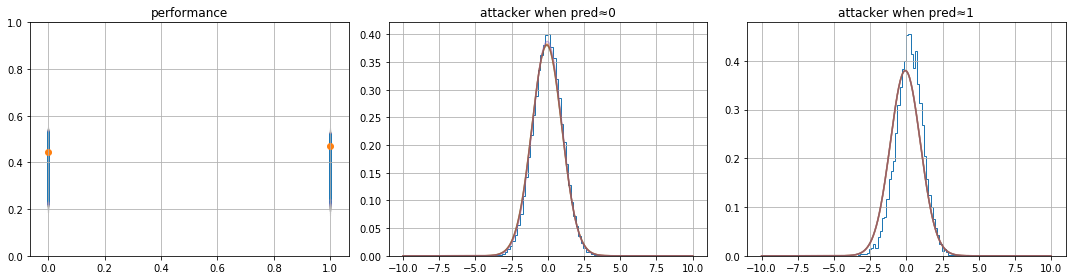

pred_means: [0.44522312, 0.47111735] mse0: 0.00048523452211526874 mse1: 0.016357854046849772


In [11]:
my_plots()

# Pre-training without adversary

In [12]:
# Pretraining of D
D.fit(X_train, y_train, epochs=50)
min_Lf = D.evaluate(X_valid, y_valid)
#print('Expected to drop from 0.479 to 0.446')

Epoch 1/10
75000/75000 [==============================] - 3s 46us/step - loss: 0.4911
Epoch 2/10
75000/75000 [==============================] - 3s 46us/step - loss: 0.4550
Epoch 3/10
75000/75000 [==============================] - 3s 44us/step - loss: 0.4538
Epoch 4/10
75000/75000 [==============================] - 3s 44us/step - loss: 0.4535
Epoch 5/10
75000/75000 [==============================] - 3s 46us/step - loss: 0.4531
Epoch 6/10
75000/75000 [==============================] - 3s 45us/step - loss: 0.4528
Epoch 7/10
75000/75000 [==============================] - 3s 45us/step - loss: 0.4525
Epoch 8/10
75000/75000 [==============================] - 3s 44us/step - loss: 0.4521
Epoch 9/10
75000/75000 [==============================] - 4s 47us/step - loss: 0.4516
Epoch 10/10
50000/50000 [==============================] - 1s 26us/step


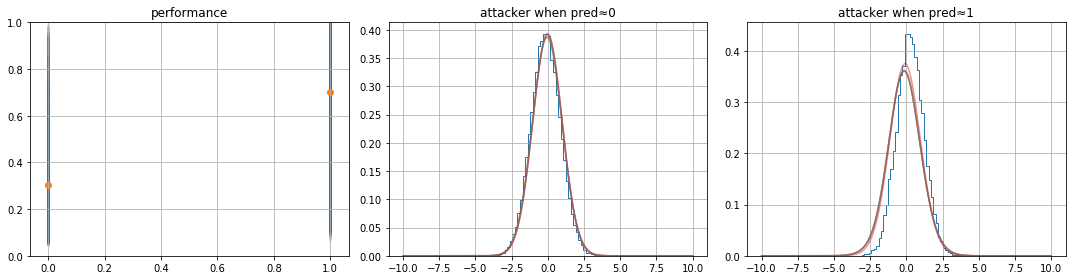

pred_means: [0.30535364, 0.7021371] mse0: 0.003061713660964813 mse1: 0.02397598141021731


In [13]:
my_plots()

In [14]:
def make_X(n_samples, z):
    X0 = p0.rvs(n_samples // 2)
    X1 = p1.rvs(n_samples // 2)
    X1[:, 1] += z
    X = np.vstack([X0, X1])
    y = np.zeros(n_samples)
    y[n_samples // 2:] = 1
    return X

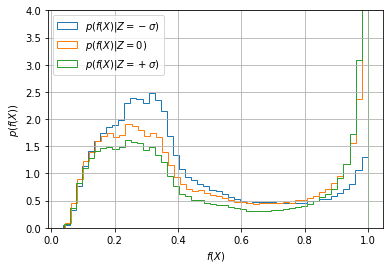

In [15]:
plt.hist(D.predict(make_X(200000, z=-1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=-\sigma)$")
plt.hist(D.predict(make_X(200000, z=0)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(D.predict(make_X(200000, z=1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=+\sigma)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.show()

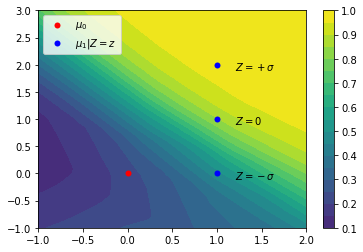

In [16]:
from scipy.interpolate import griddata

X_test = np.random.rand(30000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
gxi, gyi = np.meshgrid(xi, yi)
zi = griddata(X_test, y_pred, (gxi.ravel(), gyi.ravel()), method="linear")
CS = plt.contourf(xi, yi, zi.reshape(len(xi), len(yi)), 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=-\sigma$", color="k")
plt.text(1.2, 1-0.1, "$Z=0$", color="k")
plt.text(1.2, 2-0.1, "$Z=+\sigma$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="upper left", scatterpoints=1)
plt.savefig("surface-plain.pdf")
plt.show()

# Adversarial training of f and r

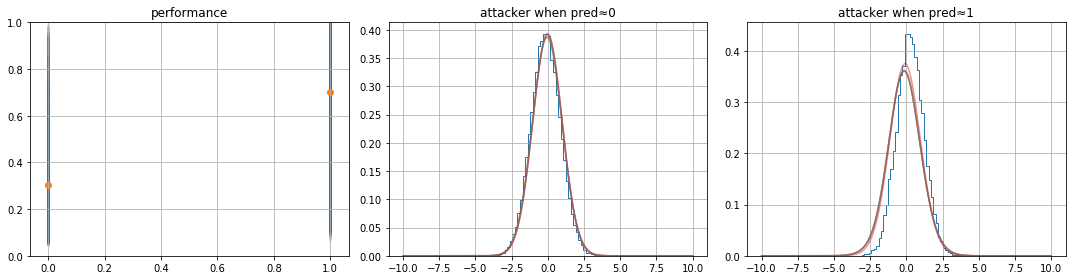

pred_means: [0.30535364, 0.7021371] mse0: 0.003061713660964813 mse1: 0.02397598141021731


In [17]:
my_plots()

In [24]:
with Context_DfR(): # Just for removing the warning
    DfR.fit(X_train, z_train, epochs=50)
#print('Expected to drop from 1.42 to 1.36')

Epoch 1/50
75000/75000 [==============================] - 8s 101us/step - loss: 1.4199
Epoch 2/50
75000/75000 [==============================] - 17s 223us/step - loss: 1.4200
Epoch 3/50
75000/75000 [==============================] - 10s 140us/step - loss: 1.4199
Epoch 4/50
75000/75000 [==============================] - 12s 163us/step - loss: 1.4199
Epoch 5/50
75000/75000 [==============================] - 11s 147us/step - loss: 1.4199
Epoch 6/50
75000/75000 [==============================] - 11s 150us/step - loss: 1.4200
Epoch 7/50
75000/75000 [==============================] - 12s 159us/step - loss: 1.4200
Epoch 8/50
75000/75000 [==============================] - 12s 166us/step - loss: 1.4199
Epoch 9/50
75000/75000 [==============================] - 12s 155us/step - loss: 1.4200
Epoch 10/50
75000/75000 [==============================] - 15s 195us/step - loss: 1.4199
Epoch 11/50
75000/75000 [==============================] - 11s 144us/step - loss: 1.4200
Epoch 12/50
75000/75000 [======

KeyboardInterrupt: 

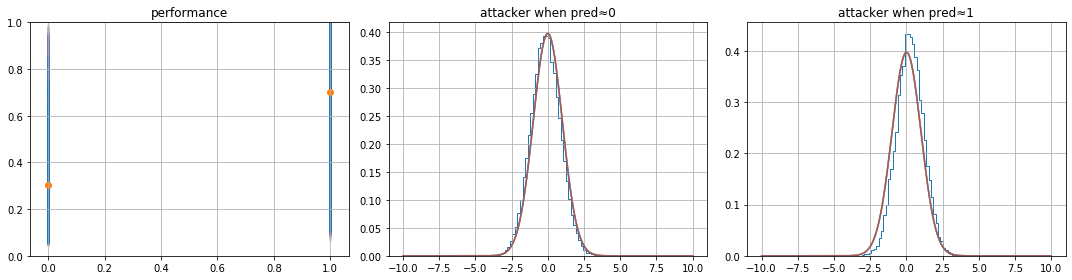

pred_means: [0.30535364, 0.7021371] mse0: 0.00434872609152096 mse1: 0.009570837089246846


In [20]:
my_plots()

In [21]:
from IPython import display

min_Lr = np.log(1 * (2. * np.pi * np.e) ** 0.5)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()  

In [22]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

<Figure size 432x288 with 0 Axes>

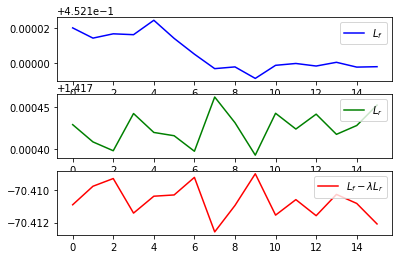

Epoch 1/1
75000/75000 [==============================] - 7s 96us/step - loss: 1.4199


KeyboardInterrupt: 

In [23]:
batch_size = 128

for i in range(201):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)
    losses["L_f - L_r"].append(l[0])
    losses["L_f"].append(l[1])
    losses["L_r"].append(-l[2])
    print(losses["L_r"][-1] / lam)
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    with Context_DRf(): # Just for removing the warning
        indices = np.random.permutation(len(X_train))[:batch_size]
        DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    # Fit R
    with Context_DfR(): # Just for removing the warning
        DfR.fit(X_train, z_train, batch_size=batch_size, epochs=1, verbose=1)


In [ ]:
my_plots()

In [ ]:
plt.hist(D.predict(make_X(200000, z=-1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=-\sigma)$")
plt.hist(D.predict(make_X(200000, z=0)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(D.predict(make_X(200000, z=1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=+\sigma)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("f-adversary.pdf")
plt.show()

In [ ]:
from scipy.interpolate import griddata


X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
gxi, gyi = np.meshgrid(xi, yi)
zi = griddata(X_test, y_pred, (gxi.ravel(), gyi.ravel()), method="linear")
CS = plt.contourf(xi, yi, zi.reshape(len(xi), len(yi)), 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)

plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=-\sigma$", color="k")
plt.text(1.2, 1-0.1, "$Z=0$", color="k")
plt.text(1.2, 2-0.1, "$Z=\sigma$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="upper left", scatterpoints=1)
plt.savefig("surface-adversary.pdf")
plt.show()

In [ ]:
def plot_losses_final(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    n_iter = 200 #len(np.array(losses["L_f"]))-1

    ax1 = plt.subplot(311)  
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, color="blue")   
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed")
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xticks([])
    plt.xlim(0, n_iter)
    plt.grid()
    plt.ylabel(r"$L_f$")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, color="green")
    plt.hlines(min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lr, values.min())
    high = max(min_Lr, values.max())
    #high = high - (high-low) * 0.1
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xlim(0, n_iter)
    plt.grid()
    plt.ylabel(r"$L_r$")
    
    ax3 = plt.subplot(313)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, color="red")  
    plt.hlines(min_Lf - lam*min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lf - lam*min_Lr, values.min())
    high = max(min_Lf - lam*min_Lr, values.max())
    #low = low + (high-low) * 0.5
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xlim(0, n_iter)
    plt.grid(axis="y")
    plt.ylabel("$L_f - \lambda L_r$")
    plt.xlabel("$T$")
    
    plt.savefig("training.pdf")
    
    plt.show()  
    
plt.rcParams["font.size"] = 10
plot_losses_final(losses)